In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

pd.set_option('display.max_columns', 33)

/home/geoff/anaconda3/envs/plume/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def score_function(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / float(y_true.shape[0])

In [3]:
def read_file_train():
    return read_csv("data/X_train.csv", index_col=0)

def read_file_train_output():
    return read_csv("data/challenge_output_data_training_file_predict_air_quality_at_the_street_level.csv", index_col=0)


def read_file_test():
    return read_csv("data/X_test.csv", index_col=0)

def set_buffer_nans_to_zero(data):
    data.fillna(0, inplace=True)



def triang_correlation_matrix(d, title):
    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    h = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    plt.xticks(rotation=35)
    plt.yticks(rotation=35)
    plt.title(title)

In [4]:
def print_to_file_pred(y, title):
    y.to_csv("results/" + title + ".csv", sep=',')

# Load Data

In [5]:
X_train = read_file_train()
X_test = read_file_test()
Y_train = read_file_train_output()
set_buffer_nans_to_zero(X_train)
set_buffer_nans_to_zero(X_test)

### Change categorical variables to numerical

In [6]:
cat_columns = ['zone_id', 'pollutant']
cats_to_drop = ['station_id']
X_train = pd.get_dummies(X_train, columns=cat_columns)
X_test = pd.get_dummies(X_test, columns=cat_columns)

### Normalize Data

In [8]:
def normalize(X):
    return X.apply(lambda x: (x-x.mean()/x.std()))

In [9]:
X = pd.concat([X_train, X_test])
idx_train = X_train.index
idx_test = X_test.index
normalized_X = normalize(X)
X_train_norm = normalized_X.loc[idx_train]
X_test_norm = normalized_X.loc[idx_test]

In [10]:
X.drop(cats_to_drop, axis=1, inplace=True)

In [11]:
import sklearn.linear_model as lin_mods

In [12]:
def scorer(estimator, X, y):
    return score_function(estimator.predict(X), y)

### Define Regressor

In [24]:
from sklearn.ensemble.forest import RandomForestRegressor

# lin_regressor = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
# model = Ridge(fit_intercept=False, normalize=False, copy_X=True)
# model = lin_mods.RidgeCV(cv=5, scoring=scorer)
model = RandomForestRegressor(n_estimators=3, n_jobs=5)

### Fit regression to train set

In [25]:
model.fit(X_train_norm.drop(cats_to_drop, axis=1), Y_train['TARGET'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3, n_jobs=5, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [26]:
pd.Series(model.feature_importances_, index=X.columns)

hlres_50             0.000797
green_5000           0.004367
hldres_50            0.001635
daytime              0.196452
route_100            0.000433
precipintensity      0.013723
precipprobability    0.012517
hlres_1000           0.005346
temperature          0.095862
is_calmday           0.020625
route_1000           0.027895
roadinvdist          0.008857
port_5000            0.009246
windbearingsin       0.088240
cloudcover           0.042828
hldres_100           0.000867
natural_5000         0.004171
hlres_300            0.007825
hldres_300           0.001310
route_300            0.045100
pressure             0.090181
route_500            0.024964
hlres_500            0.007685
hlres_100            0.008031
industry_1000        0.001174
windbearingcos       0.054294
windspeed            0.091368
hldres_500           0.002829
hldres_1000          0.017935
zone_id_0.0          0.001734
zone_id_1.0          0.000601
zone_id_2.0          0.000272
zone_id_3.0          0.000277
zone_id_4.

In [27]:
%matplotlib inline

In [28]:
pd.Series(model.coef_[0], index=X.columns)

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

### Predict on test set

In [29]:
y_pred = model.predict(X_test_norm.drop(cats_to_drop, axis=1)).clip(0)

In [30]:
y_pred_train = model.predict(X_train_norm.drop(cats_to_drop, axis=1))

In [31]:
y_pred_train = pd.Series(y_pred_train, index=idx_train, name='TARGET')
y_pred_train

ID
0         42.000000
1         23.333333
2         12.666667
3         22.000000
4         11.666667
5         17.000000
6          9.333333
7         15.333333
8         12.333333
9         14.000000
10        31.000000
11        15.333333
12        37.333333
13        17.000000
14        58.000000
15        40.000000
16        61.000000
17        22.000000
18        46.333333
19        21.333333
20        26.000000
21        29.000000
22        23.333333
23        28.333333
24        24.000000
25        28.000000
26        24.000000
27        28.000000
28        19.932421
29        29.000000
            ...    
448139    11.333333
448140    16.000000
448141    11.000000
448142     8.000000
448143     5.000000
448144     8.000000
448145     5.666667
448146    26.666667
448147     5.000000
448148    17.000000
448149     5.333333
448150    16.000000
448151     5.000000
448152    15.000000
448153     5.666667
448154    25.555556
448155     5.000000
448156    27.333334
448157     5.0000

In [32]:
np.mean((np.array(Y_train) - np.array(y_pred_train))**2)

MemoryError: 

In [34]:
print_to_file_pred(pd.DataFrame(y_pred, index=idx_test, columns=["TARGET"]), 'linear_reg')

In [35]:
Y_train.std(), Y_train.mean(), y_pred_train.std(), y_pred_train.mean()

(TARGET    16.520396
 dtype: float64, TARGET    20.286938
 dtype: float64, 15.661590573378136, 20.321528782113891)

In [36]:
y_pred2 = np.maximum(y_pred_train, 0)

In [44]:
diff = (y_pred_train - Y_train)

MemoryError: 

(0, 500)

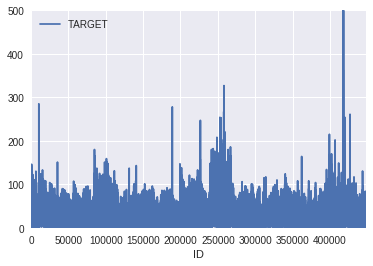

In [40]:
Y_train.plot()
import matplotlib.pyplot as plt
plt.ylim([0, 500])